In [1]:
%pip install tensorflow numpy matplotlib pandas scikit-learn seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

2025-04-05 11:55:34.419759: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 11:55:34.420636: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 11:55:34.424122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 11:55:34.429081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743846934.436923 1856641 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743846934.43

In [187]:
import json
from pathlib import Path

hr_data = []

for json_file in Path('rawhr').glob('*.json'):

    with open(json_file, 'r') as file:
        data = json.load(file)
    
        hr = list(map(lambda x: x[1], data['heartRateValues']))

        if len(hr) != 720:
            print(json_file.name )
        hr_data.append(hr)

hr_data = hr_data + hr_data + hr_data +  hr_data + hr_data + hr_data
hr_data = hr_data + hr_data + hr_data +  hr_data + hr_data + hr_data
hr_data = hr_data + hr_data + hr_data +  hr_data + hr_data + hr_data
hr_data = np.array(hr_data)
print(hr_data.shape)

(4752, 720)


In [166]:
def plot_hr(data):
    plt.figure(figsize=(18, 4))
    plt.plot(data)
    plt.ylim(0,200)
    plt.show()

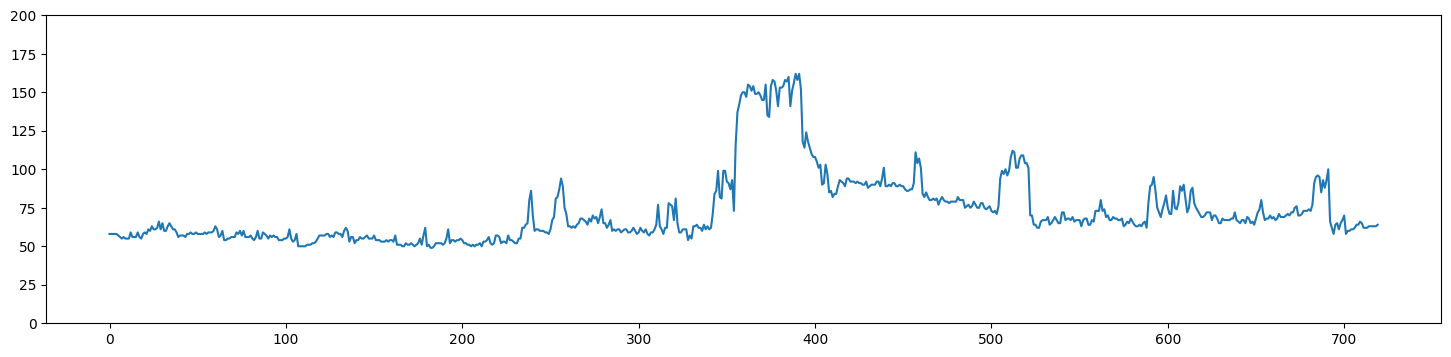

In [28]:
plot_hr(hr_data[2])

In [188]:
x_train = hr_data.astype('float32') / 250.0

x_train_normal, x_val_normal  = train_test_split(x_train, test_size=0.25, random_state=42)

print(x_train.shape, x_train_normal.shape, x_val_normal.shape)

(4752, 720) (3564, 720) (1188, 720)


In [189]:
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Dense(720,"relu")(input_img)
    x = Dense(360,"relu" )(x)
    x = Dense(120,"relu")(x)
    x = Dense(12,"relu")(x)
    x = Dense(120,"relu")(x)

    # Decoder
    x = Dense(360,"relu")(x)
    x = Dense(720,"relu")(x)
    
    autoencoder = Model(input_img, x)
    return autoencoder

In [190]:
# Build the autoencoder model
input_shape = (720,)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 720)            │       519,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 360)            │       259,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 120)            │        43,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 12)             │         1,452 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 120)            │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 360)            │        43,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 720)            │       259,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,128,492 (4.30 MB)

 Trainable params: 1,128,492 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

In [191]:
# Train the autoencoder on the training data
history = autoencoder.fit(x_train_normal, x_train_normal,
                          epochs=20,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_val_normal, x_val_normal))

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0360 - val_loss: 0.0301
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0301 - val_loss: 0.0298
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0289 - val_loss: 0.0244
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0235 - val_loss: 0.0209
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0199 - val_loss: 0.0180
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0176 - val_loss: 0.0150
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141 - val_loss: 0.0121
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 12/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

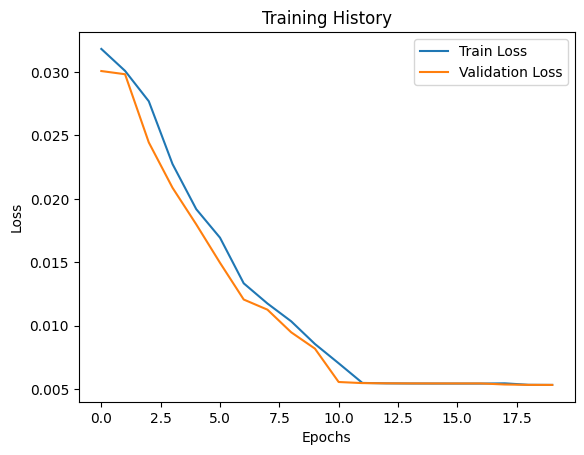

In [192]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [193]:
# Calculate MSE for the validation dataset
x_out_val = autoencoder.predict(x_val_normal)
mse_val = np.mean(np.square(x_val_normal - x_out_val))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(1188, 720)
(1188, 720)


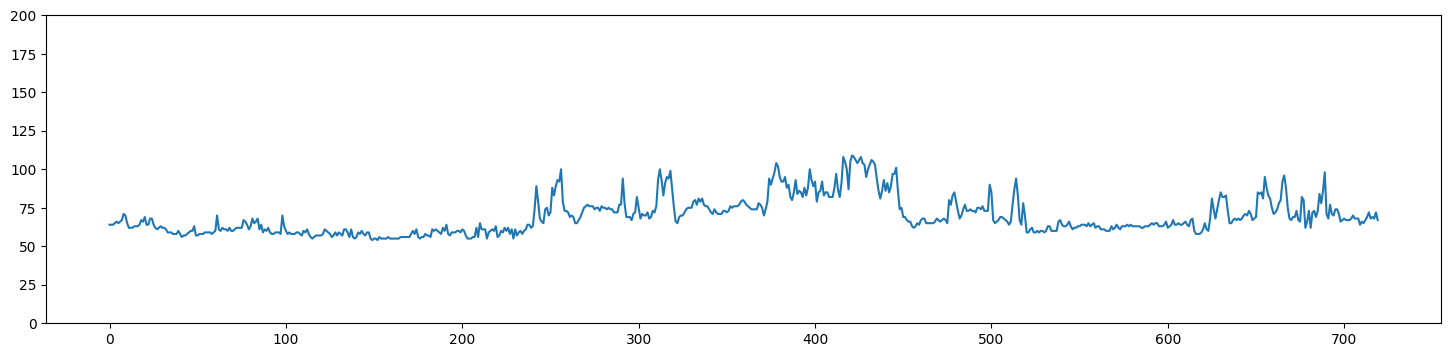

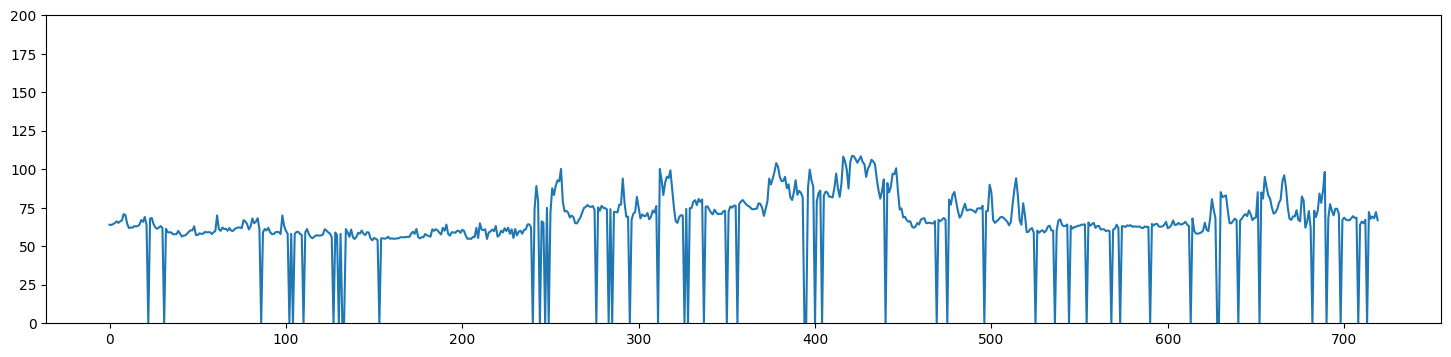

In [194]:

print(x_val_normal.shape)
print(x_out_val.shape)

plot_hr(x_val_normal[1].flatten()*250)
plot_hr(x_out_val[1].flatten()*250)